In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/tmp/kaggle/kgd_barcelona/src


In [3]:
import os
import ast
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# from utils.tokenizers import update_tokenizers
# package_path = "/opt/conda/lib/python3.8/site-packages/transformers"
# input_dir = "../input/deberta_fast_tokenizer"

# update_tokenizers(package_path, input_dir)

In [5]:
from data.dataset import *
from data.processing import *
from data.preparation import *
from data.tokenization import *

from training.main import k_fold
from models import NERTransformer

# from utils.plot import *
from utils.logger import prepare_log_folder, save_config, create_logger

from params import *

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Folds

In [6]:
# from sklearn.model_selection import KFold
# K = 4

# df = pd.read_csv(DATA_PATH + "info_train.csv")

# skf = KFold(n_splits=K, shuffle=True, random_state=42)
# splits = skf.split(df)

# df['fold'] = -1
# for i, (_, val_idx) in enumerate(splits):
#     df.loc[val_idx, "fold"] = i
    
# df_folds = df[["notebook_id", "fold"]]
# df_folds.to_csv(f"/worskpace/folds_kgd_{K}.csv", index=False)

## Data

In [7]:
df = load_and_prepare(DATA_PATH)

df_test = load_and_prepare_test(DATA_PATH)

In [30]:
print((df['target'] > 0).sum())
print((df['target'] > 10).sum())
print((df['target'] > 100).sum())
print((df['target'] > 1000).sum())
print((df['target'] > 10000).sum())

85249
6623
2260
670
163


In [33]:
for t in df[df['target'] > 10000]['source']:
    print(t)
    print('\n#################################################\n')

best_metric = -1

best_metric_epoch = -1

epoch_loss_values = list()

auc_metric = ROCAUCMetric()

metric_values = list()



for epoch in range(epoch_num):

    print('-' * 10)

    print(f"epoch {epoch + 1}/{epoch_num}")

    model.train()

    epoch_loss = 0

    step = 0



    for batch_data in train_loader:

        step += 1

        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())     ##### 

        loss = loss_function(outputs, labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

        epoch_len = len(train_ds) // train_loader.batch_size



    epoch_loss /= step

    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")



    if (epoch + 1) % val_interval == 0:

        model.eval()

        with t

<AxesSubplot: xlabel='total_execution_time', ylabel='Count'>

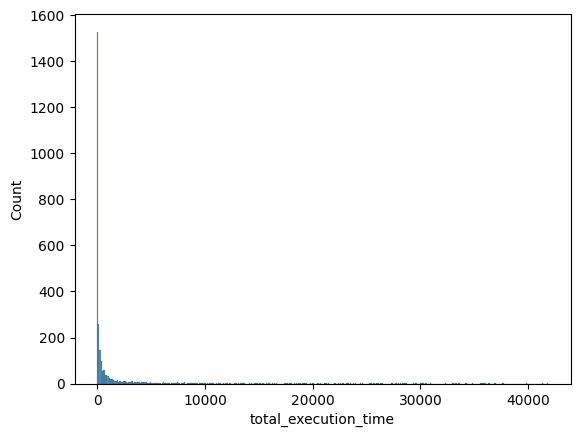

In [9]:
y = pd.read_csv(DATA_PATH + "info_train.csv")
sns.histplot(y['total_execution_time'])

In [10]:
# %%time
# df = load_and_prepare_pretrain("../output/pl_4/df_pl_0.csv", root=DATA_PATH, lower=False)

# # df = load_and_prepare_pretrain('../output/pl_5/df_pl.csv', DATA_PATH)

In [11]:
name = "microsoft/deberta-base"
name = "microsoft/codebert-base"

In [12]:
# lens = []
# tokenizer = AutoTokenizer.from_pretrained(name)

# for i in tqdm(range(len(df.sample(1000)))):
#     lens.append(
#         len(tokenizer(
#             df['clean_text'][i],
#         )['input_ids'])
#     )
# sns.displot(np.clip(lens, 0, 512))
# print('Max length :', np.max(lens))

In [13]:
tokenizer = get_tokenizer(name, add_special_tokens=False)
dataset = PatientNoteDataset(df, tokenizer, max_len=310)

In [14]:
for idx in tqdm(range(len(dataset))):
    data = dataset[idx]
    break

  0%|          | 0/85249 [00:00<?, ?it/s]


### Model

In [15]:
model = NERTransformer(name, num_classes=1)

In [16]:
model(data["ids"].unsqueeze(0), data["token_type_ids"].unsqueeze(0))

tensor([[-0.0785]], grad_fn=<AddmmBackward0>)

# Training

In [17]:
BATCH_SIZES = {
    "microsoft/deberta-v3-base": 32,
    "microsoft/codebert-base": 32,
    "microsoft/deberta-v3-large": 32,
}

LRS = {
    "microsoft/deberta-v3-base": 3e-5,
    "microsoft/codebert-base": 3e-5,
    "microsoft/deberta-v3-large": 3e-5,
}

MAX_LENS = {
    "microsoft/deberta-v3-base": 512,
    "microsoft/codebert-base": 512,
    "microsoft/deberta-v3-large": 512,
}

In [18]:
class Config:
    # General
    seed = 2222
    device = "cuda"
    
    # Splits
    k = 4
    random_state = 2222
    selected_folds = [0, 1, 2, 3]
    folds_file = "/workspace/folds_kgd_4.csv"

    # Architecture
    name = "microsoft/codebert-base"

    pretrained_weights = None 

    no_dropout = False
    use_conv = False
    use_lstm = False
    nb_layers = 1
    nb_ft = 128
    conv_kernel = 5
    drop_p = 0 if no_dropout else 0.1
    multi_sample_dropout = False
    num_classes = 1

    # Texts
    max_len_train = MAX_LENS[name]
    max_len = 512
    lower = True

#     extra_data_path = OUT_PATH + "pl_case5/"
    extra_data_path = None  # OUT_PATH + "pl_6/df_pl.csv"

    # Training    
    loss_config = {
        "name": "mse",  # dice, ce, bce
        "smoothing": 0,  # 0.01
        "activation": "",  # "sigmoid", "softmax"
    }

    data_config = {
        "batch_size": BATCH_SIZES[name],
        "val_bs": BATCH_SIZES[name] * 2,
        "use_len_sampler": True,
        "pad_token": 1 if "roberta" in name else 0,
    }

    optimizer_config = {
        "name": "AdamW",
        "lr": 5e-5,
        "lr_transfo": LRS[name],
        "lr_decay": 0.99,
        "warmup_prop": 0.1,
        "weight_decay": 1,
        "betas": (0.5, 0.99),
        "max_grad_norm": 1.,
        # AWP
        "use_awp": False,
        "awp_start_step": 1000,
        "awp_lr": 1,
        "awp_eps": 5e-5 if "xlarge" in name else 1e-3,
        "awp_period": 3,
        # SWA
        "use_swa": False,
        "swa_start": 9400,
        "swa_freq": 500,
    }

    gradient_checkpointing = False
    acc_steps = 1
    epochs = 1

    use_fp16 = True

    verbose = 1
    verbose_eval = 1000

In [19]:
DEBUG = True
log_folder = None

In [20]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

pred_val, pred_test = k_fold(
    Config,
    df,
    df_test=df_test,
    log_folder=log_folder
)


-------------   Fold 1 / 4  -------------

    -> 64157 training texts
    -> 21092 validation texts
    -> 124646401 trainable parameters

Epoch 01/01  (step 1000)	lr=1.5e-05	 t=757s	 loss=1151213.417	 val_loss=913356.062	 score=954.793
Epoch 01/01  (step 2005)	lr=2.5e-07	 t=759s	 loss=1393382.299	 val_loss=913303.375	 score=954.949


### Errors

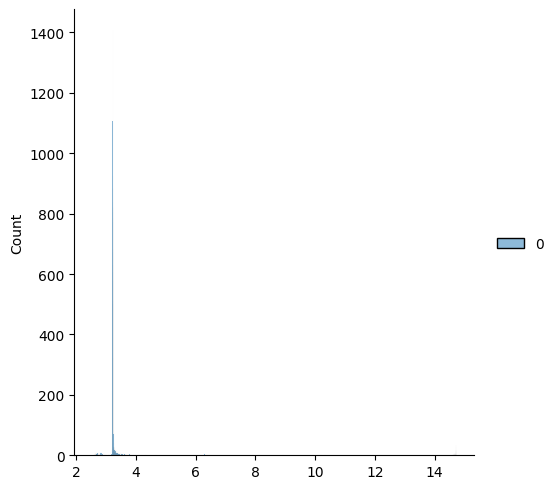

In [28]:
sns.displot(pred_val)

In [24]:
pred_val.mean()

3.6100218

In [25]:
pred_val.max()

14.718819

In [26]:
pred_val.std()

1.8501861

Done